In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deeplenstronomy.visualize import view_image, view_image_rgb
from astropy.io import fits
from lenstronomy.Data.psf import PSF
import autolens as al
import autolens.plot as aplt
import autofit as af
from ipywidgets import *

num_simulated_lenses = 100
bands_simulated = ['g', 'r', 'i', 'z', 'Y']

image_pre_path = './simulations/fits_files/'

%matplotlib inline

2022-03-09 17:56:26,505 - autoconf.conf - WARNING - Pushing new config with path /home/joao/.local/lib/python3.8/site-packages/autofit/config


2022-03-09 17:56:26,694 - autoconf.conf - WARNING - Pushing new config with path /home/joao/.local/lib/python3.8/site-packages/autogalaxy/config
2022-03-09 17:56:26,830 - autoconf.conf - WARNING - Pushing new config with path /home/joao/.local/lib/python3.8/site-packages/autolens/config


In [2]:
metadata = pd.read_csv(image_pre_path+'metadata.txt')
metadata.head()

,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,seeing-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,0,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,0.943,...,0.713107,4.791211,0.713107,4.791211,0.713107,4.791211,0.713107,4.791211,0.713107,4.791211
2,2,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.062,...,0.917311,5.659223,0.917311,5.659223,0.917311,5.659223,0.917311,5.659223,0.917311,5.659223
3,3,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.302,...,0.331149,1.605525,0.331149,1.605525,0.331149,1.605525,0.331149,1.605525,0.331149,1.605525
4,4,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.001,...,0.613173,5.218114,0.613173,5.218114,0.613173,5.218114,0.613173,5.218114,0.613173,5.218114


In [3]:
dl_results = pd.read_csv('./dl_results/DL_results.csv')
dl_results.head()

,sys,nsersic_pred,nsersic_true,rsersic_pred,rsersic_true,thetae_pred,thetae_true
0,6724.0,3.596910,3.346877,6.450897,7.128520,4.014574,3.810371
1,6474.0,4.226019,4.437576,7.009513,7.760050,4.060344,3.796621
2,4680.0,3.345616,2.880337,6.313189,6.676155,4.276320,3.958710
3,863.0,4.366602,3.749100,7.990428,8.290760,3.233206,3.111711
4,7287.0,4.010775,4.032496,6.966737,7.123261,3.436713,3.338077


In [4]:
limits = np.histogram(dl_results['thetae_true'], bins=50)[1]

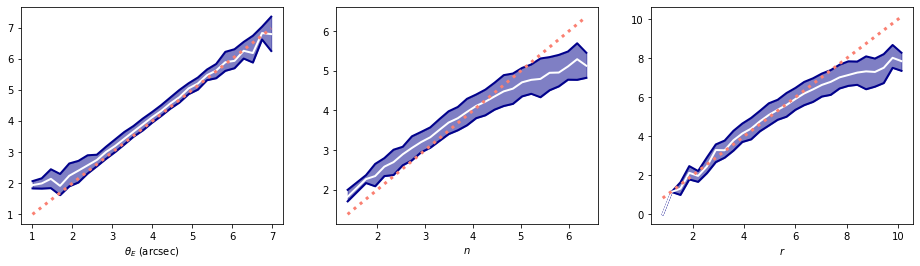

In [5]:
variables = ['thetae', 'nsersic', 'rsersic']
variables_lattex = ['$θ_E$ (arcsec)', '$n$', '$r$']

mean = []
upper_sigma = []
lower_sigma = []
X_ = []
saved_limits = []
for i in range(3):
    mean.append([])
    upper_sigma.append([])
    lower_sigma.append([])
    X_.append([])
    
for i in range(0, len(variables)):
    limits = np.histogram(dl_results[variables[i]+'_true'], bins=30)[1]
    saved_limits.append(limits)
    for j in range(0, len(limits)-1):
        if len(dl_results[variables[i]+'_pred'][(dl_results[variables[i]+'_true'] < limits[j+1]) & (dl_results[variables[i]+'_true'] > limits[j])]) > 0:
            mean[i].append(np.mean(dl_results[variables[i]+'_pred'][(dl_results[variables[i]+'_true'] < limits[j+1]) & (dl_results[variables[i]+'_true'] > limits[j])]))
            lower_error, upper_error = np.percentile(dl_results[variables[i]+'_pred'][(dl_results[variables[i]+'_true'] < limits[j+1]) & (dl_results[variables[i]+'_true'] > limits[j])], [15.85, 84.05])
            lower_sigma[i].append(lower_error)
            upper_sigma[i].append(upper_error)
            X_[i].append(limits[j] + (limits[i+1]-limits[i])/2)
    
fig, ax = plt.subplots(1, len(variables), figsize=(16, 4))
for i in range(0, len(variables)):
    ax[i].fill_between(np.array(X_[i]), np.array(lower_sigma[i]), np.array(upper_sigma[i]), color = 'darkblue', alpha=0.5, zorder=1)
    ax[i].plot(X_[i], np.array(lower_sigma[i]), 'darkblue', lw=2, zorder=2)
    ax[i].plot(X_[i], np.array(upper_sigma[i]), 'darkblue', lw=2, zorder=2)
    ax[i].plot(X_[i], mean[i], "w", lw=2, zorder=2)
    ax[i].plot(X_[i],X_[i], 'salmon', lw=3., linestyle='dotted', zorder=3)
    ax[i].set_xlabel(variables_lattex[i])

In [6]:
bayes_sys_fit = metadata.iloc[dl_results['sys']]
bayes_sys_fit = bayes_sys_fit[(bayes_sys_fit['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'] < 6.) & (bayes_sys_fit['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'] > 2.)]
bayes_sys_fit = bayes_sys_fit[(bayes_sys_fit['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'] < 5.) & (bayes_sys_fit['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'] > 2.5)]
bayes_sys_fit = bayes_sys_fit[(bayes_sys_fit['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'] < 6.5) & (bayes_sys_fit['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'] > 2.5)]
bayes_sys_fit.reset_index(inplace=True)

In [7]:
bayes_sys_fit.head()

,index,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,3018,3018,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.420062,3.956041,0.420062,3.956041,0.420062,3.956041,0.420062,3.956041,0.420062,3.956041
1,3088,3088,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.930279,4.575132,0.930279,4.575132,0.930279,4.575132,0.930279,4.575132,0.930279,4.575132
2,543,543,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.895384,3.550403,0.895384,3.550403,0.895384,3.550403,0.895384,3.550403,0.895384,3.550403
3,9294,9294,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.520792,5.157018,0.520792,5.157018,0.520792,5.157018,0.520792,5.157018,0.520792,5.157018
4,12071,12071,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.434458,3.278104,0.434458,3.278104,0.434458,3.278104,0.434458,3.278104,0.434458,3.278104


In [8]:
pixel_scale = bayes_sys_fit['pixel_scale-g'][0]
exposure_time = bayes_sys_fit['exposure_time-g'][0]
N_sys = 10

cutouts = []
psf = []
noise_map = []
for i in range(N_sys):
    cutouts.append ([])
    psf.append([])
    noise_map.append([])

for i in range(N_sys):
    for j in range(0, len(bands_simulated)):
        cutouts[i].append(fits.open(image_pre_path+bands_simulated[j]+'/'+str(bayes_sys_fit['OBJID-g'][i])+'.fits')[0].data)
        kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': bayes_sys_fit['seeing-'+bands_simulated[j]][i], 'pixel_size': bayes_sys_fit['pixel_scale-g'][0], 'truncation': 4/bayes_sys_fit['seeing-'+bands_simulated[j]][i]}
        psf_class = PSF(**kwargs_psf)
        psf[i].append(psf_class.kernel_point_source/np.max(psf_class.kernel_point_source))
        noise_map[i].append(np.sqrt((cutouts[i][j]*exposure_time+float(bayes_sys_fit['sky_brightness-'+str(bands_simulated[j])][i]**2)))/exposure_time)

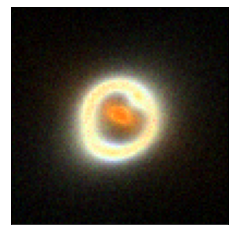

In [9]:
view_image_rgb(cutouts[0])

## building inner and outter lens light 

* lens light mask

In [10]:
image_model_optionlist = np.linspace(0, len(cutouts), len(cutouts)+1, dtype=int)

In [11]:
def update_graph(n):
    """
    def function to update our visual graph
    i: int
        option, system
    """
    imaging_for_mask = al.Imaging(al.Array2D.manual(np.array(cutouts[n][2], dtype=float), pixel_scales=float(pixel_scale)), # cutout
                                  al.Array2D.manual(np.array(noise_map[n][2], dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                                  al.Kernel2D.manual(np.array(psf[n][2], dtype=float), pixel_scales=float(pixel_scale))) # psf

    mask = al.Mask2D.circular(shape_native=imaging_for_mask.shape_native, pixel_scales=imaging_for_mask.pixel_scales, radius=1.2)
    imaging_for_mask = imaging_for_mask.apply_mask(mask=mask)

    visuals_2d = aplt.Visuals2D()
    array_plotter = aplt.Array2DPlotter(array=imaging_for_mask.image, visuals_2d=visuals_2d)
    array_plotter.figure_2d()
    
n = widgets.Dropdown(options=image_model_optionlist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,n = n)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=0),…

* lens system mask

In [12]:
def update_graph(n):
    """
    def function to update our visual graph
    i: int
        option, system
    """
    imaging_for_mask = al.Imaging(al.Array2D.manual(np.array(cutouts[n][0], dtype=float), pixel_scales=float(pixel_scale)), # cutout
                                  al.Array2D.manual(np.array(noise_map[n][0], dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                                  al.Kernel2D.manual(np.array(psf[n][0], dtype=float), pixel_scales=float(pixel_scale))) # psf

    mask = al.Mask2D.circular(shape_native=imaging_for_mask.shape_native, pixel_scales=imaging_for_mask.pixel_scales, radius=8.0)
    imaging_for_mask = imaging_for_mask.apply_mask(mask=mask)

    visuals_2d = aplt.Visuals2D()
    array_plotter = aplt.Array2DPlotter(array=imaging_for_mask.image, visuals_2d=visuals_2d)
    array_plotter.figure_2d()
    
n = widgets.Dropdown(options=image_model_optionlist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,n = n)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=0),…

## modelization 

In [13]:
class apply_pipeline:
    def __init__(self, imaging_object, system_identifier_name, lens_redshift, source_redshift, core_usage=3):
        
        self.imaging_object = imaging_object
        self.system_identifier_name = system_identifier_name
        self.lens_redshift = lens_redshift
        self.source_redshift = source_redshift
        self.core_usage = core_usage
        
    def fit_lens_light(self, nlive, lens_light_radius=1.2):
        # applying a mask
        mask = al.Mask2D.circular(shape_native=self.imaging_object.shape_native, pixel_scales=self.imaging_object.pixel_scales, radius=lens_light_radius)
        masked_object = self.imaging_object.apply_mask(mask=mask)
        # model
        source_bulge = af.Model(al.lmp.EllSersic)
        source_galaxy_model = af.Model(al.Galaxy,
                                         redshift=self.source_redshift,
                                         bulge_0=source_bulge)
        lens_galaxy_model = af.Model(al.Galaxy,
                                       redshift=self.lens_redshift)
        # combining our previous components
        lens_light_model = af.Collection(galaxies=af.Collection(lens=lens_galaxy_model, source=source_galaxy_model))
        # autolens fit full bright distribution
        search = af.DynestyStatic(path_prefix = './',
                                  unique_tag = str(self.system_identifier_name)+'_lens_light_step_0',
                                  nlive = nlive,
                                  number_of_cores = self.core_usage) # be carefull here! verify your core numbers
        analysis = al.AnalysisImaging(dataset=masked_object)
        step_0_result = search.fit(model=lens_light_model, analysis=analysis)
        return step_0_result
    
    def fit_system(self, original_image, original_noise_map, original_psf, unmasked_lens_model, nlive, pixel_scale, prior_variables=[], predictions_dataframe=[], lower_limits=[], upper_limits=[], system_radius=8.0, use_predictions=False):
        original_image = al.Array2D.manual(np.array(original_image, dtype=float), pixel_scales=float(pixel_scale))
        residual_image = original_image - unmasked_lens_model
        new_image_object = al.Imaging(residual_image, # cutout
                                      al.Array2D.manual(np.array(original_noise_map, dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                                      al.Kernel2D.manual(np.array(original_psf, dtype=float), pixel_scales=float(pixel_scale))) # psf

        mask = al.Mask2D.circular(shape_native=new_image_object.shape_native, pixel_scales=new_image_object.pixel_scales, radius=system_radius)
        masked_object = new_image_object.apply_mask(mask=mask)

        # source galaxy model
        bulge = af.Model(al.lmp.EllSersic)
        source_galaxy_model = af.Model(al.Galaxy,
                                       redshift=self.source_redshift,
                                       bulge=bulge)
        # lens galaxy model
        lens_galaxy_model = af.Model(al.Galaxy,
                                     redshift=self.lens_redshift ,
                                     mass=al.mp.EllIsothermal)    
        if use_predictions:
            priors = []
            for n in range(0, len(prior_variables)):
                priors.append([float(predictions_dataframe[prior_variables[n]+'_pred']-0.1*predictions_dataframe[prior_variables[n]+'_pred']), float(predictions_dataframe[prior_variables[n]+'_pred']+0.1*predictions_dataframe[prior_variables[n]+'_pred'])])
                
                '''
                lowest_index = np.where(np.abs(np.array(lower_limits[n])-float(predictions_dataframe[prior_variables[n]+'_pred'])) == np.min(np.abs(np.array(lower_limits[n])-float(predictions_dataframe[prior_variables[n]+'_pred']))))[0][0]
                highest_index = np.where(np.abs(np.array(upper_limits[n])-float(predictions_dataframe[prior_variables[n]+'_pred'])) == np.min(np.abs(np.array(upper_limits[n])-float(predictions_dataframe[prior_variables[n]+'_pred']))))[0][0]+1
                print('=============')
                print(lower_limits[n][lowest_index], upper_limits[n][highest_index])
                print(float(predictions_dataframe[prior_variables[n]+'_pred'])-lower_limits[n][lowest_index])
                print(float(predictions_dataframe[prior_variables[n]+'_pred'])-upper_limits[n][highest_index])
                priors.append([float(predictions_dataframe[prior_variables[n]+'_pred'])-2*np.abs(float(predictions_dataframe[prior_variables[n]+'_pred'])-lower_limits[n][lowest_index]), float(predictions_dataframe[prior_variables[n]+'_pred'])+2*np.abs(float(predictions_dataframe[prior_variables[n]+'_pred'])-upper_limits[n][highest_index])]) 
                '''
            lens_galaxy_model.mass.einstein_radius = af.UniformPrior(lower_limit=priors[0][0], upper_limit=priors[0][1])
            source_galaxy_model.bulge.sersic_index  = af.UniformPrior(lower_limit=priors[1][0], upper_limit=priors[1][1])
            source_galaxy_model.bulge.effective_radius = af.UniformPrior(lower_limit=priors[2][0], upper_limit=priors[2][1])
            

        autolens_model = af.Collection(galaxies=af.Collection(lens=lens_galaxy_model, source=source_galaxy_model))
        
        # autolens fit full bright distribution
        search = af.DynestyStatic(path_prefix = './',
                                  unique_tag = str(self.system_identifier_name) + '_lens_light_step_1',
                                  nlive = nlive,
                                  number_of_cores = self.core_usage) # be carefull here! verify your core numbers
        analysis = al.AnalysisImaging(dataset=masked_object)
        step_1_result = search.fit(model=autolens_model, analysis=analysis) # fbd = full bright distribution
        return step_1_result

In [14]:
for i in range(0, N_sys):
    imaging_0 = al.Imaging(al.Array2D.manual(np.array(cutouts[i][0], dtype=float), pixel_scales=float(pixel_scale)), # cutout
                       al.Array2D.manual(np.array(noise_map[i][0], dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                       al.Kernel2D.manual(np.array(psf[i][0], dtype=float), pixel_scales=float(pixel_scale))) # psf
    zl = bayes_sys_fit['PLANE_1-REDSHIFT-g'][i]
    zs = bayes_sys_fit['PLANE_2-REDSHIFT-g'][i]
    pipeline = apply_pipeline(imaging_0, i, zl, zs)
    result = apply_pipeline.fit_lens_light(pipeline, nlive=30, lens_light_radius=1.2)
    pipeline.fit_system(cutouts[i][0], noise_map[i][0], psf[i][0], result.unmasked_model_image, nlive=30, pixel_scale=pixel_scale, prior_variables=variables, predictions_dataframe=dl_results[dl_results['sys']==bayes_sys_fit['OBJID-g'][i]], lower_limits=lower_sigma, upper_limits=upper_sigma, use_predictions=True)

2022-03-09 17:56:29,268 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 17:56:29,268 - root - INFO - Starting search
2022-03-09 17:56:29,310 - root - INFO - Already completed, skipping non-linear search.
2022-03-09 17:56:29,319 - root - INFO - Removing zip file
2022-03-09 17:56:29,692 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 17:56:29,693 - root - INFO - Starting search
2022-03-09 17:56:29,774 - root - INFO - Already completed, skipping non-linear search.
2022-03-09 17:56:29,801 - root - INFO - Removing zip file
2022-03-09 17:56:30,305 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 17:56:30,307 - root - INFO - Starting search
2022-03-09 17:56:30,343 - root - INFO - Already completed, skipping non-linear search.
2022-03-09 17:56:30,352 - root - INFO - Removing zip file
2022-03-09 17:56:30,718 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 17:56:30,720 - root - INFO - Starting sear

/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
173it [00:05, 34.28it/s, bound: 21 | nc: 5 | ncall: 1505 | eff(%): 11.495 | loglstar:   -inf < -59.938 <    inf | logz: -68.474 +/-    nan | dlogz: 57.665 >  0.039]       /home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
600it [00:19, 30.43it/s, +30 | bound: 143 | nc: 1 | ncall: 5032 | eff(%): 12.520 | loglstar:   -inf < 17.258 

2022-03-09 17:56:51,559 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
603it [00:00, 8889.24it/s, +30 | bound: 144 | nc: 1 | ncall: 5054 | eff(%): 12.525 | loglstar:   -inf < 17.267 <    inf | logz:  0.762 +/-    nan | dlogz:  0.001 >  0.039]


2022-03-09 17:57:00,054 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
603it [00:00, 383671.92it/s, +30 | bound: 144 | nc: 1 | ncall: 5054 | eff(%): 12.525 | loglstar:   -inf < 17.267 <    inf | logz:  0.762 +/-    nan | dlogz:  0.001 >  0.039]


2022-03-09 17:57:08,095 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


2022-03-09 17:57:14,881 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


2022-03-09 17:57:34,513 - root - INFO - Removing zip file
2022-03-09 17:57:34,870 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 17:57:34,871 - root - INFO - Starting search
2022-03-09 17:57:34,875 - root - INFO - Saving path info
2022-03-09 17:57:34,935 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 17:57:34,937 - root - INFO - number_of_cores == 3...
2022-03-09 17:57:34,939 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 17:57:34,948 - process 0 - INFO - created
2022-03-09 17:57:34,966 - process 1 - INFO - created
2022-03-09 17:57:34,983 - process 2 - INFO - created
2022-03-09 17:57:35,166 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2022-03-09 17:57:35,576 - root - INFO - No Dynesty samples found, beginning new non-linear search. 


/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
106it [00:05, 16.01it/s, bound: 4 | nc: 5 | ncall: 1004 | eff(%): 10.558 | loglstar:   -inf < -3190.346 <    inf | logz: -3197.916 +/-  5.321 | dlogz: 2681.043 >  0.039] /home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
618it [00:36, 16.74it/s, +30 | bound: 149 | nc: 1 | ncall: 5039 | eff(%): 12.860 | loglstar:   -inf < 1018.940 <    inf | logz: 994.578 +/-  5.550 | dlogz:  1.080 >  0.039]


2022-03-09 17:58:12,826 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 17:59:25,377 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


1117it [00:00, 875217.18it/s, +30 | bound: 289 | nc: 1 | ncall: 8827 | eff(%): 12.994 | loglstar:   -inf < 1032.836 <    inf | logz: 999.463 +/-  5.452 | dlogz:  0.001 >  0.039]


2022-03-09 18:00:15,391 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:01:01,990 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:02:10,597 - root - INFO - Removing zip file
2022-03-09 18:02:11,042 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:02:11,043 - root - INFO - Starting search
2022-03-09 18:02:11,048 - root - INFO - Saving path info
2022-03-09 18:02:11,097 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:02:11,101 - root - INFO - number_of_cores == 3...
2022-03-09 18:02:11,102 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:02:11,114 - process 0 - INFO - created
2022-03-09 18:02:11,133 - process 1 - INFO - created
2022-03-09 18:02:11,152 - process 2 - INFO - created
2022-03-09 18:02:11,445 - autofit.no

/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
534it [00:18, 29.34it/s, +30 | bound: 132 | nc: 1 | ncall: 5032 | eff(%): 11.208 | loglstar:   -inf < -0.438 <    inf | logz: -16.009 +/-  0.948 | dlogz:  0.005 >  0.039]


2022-03-09 18:02:30,043 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


581it [00:01, 336.28it/s, +30 | bound: 146 | nc: 1 | ncall: 5410 | eff(%): 11.294 | loglstar:   -inf < -0.232 <    inf | logz: -16.005 +/-  0.941 | dlogz:  0.001 >  0.039]


2022-03-09 18:02:40,928 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
581it [00:00, 388906.90it/s, +30 | bound: 146 | nc: 1 | ncall: 5410 | eff(%): 11.294 | loglstar:   -inf < -0.232 <    inf | logz: -16.005 +/-  0.941 | dlogz:  0.001 >  0.039]

2022-03-09 18:02:48,872 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).



/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


2022-03-09 18:02:57,021 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


2022-03-09 18:03:18,941 - root - INFO - Removing zip file
2022-03-09 18:03:19,308 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:03:19,310 - root - INFO - Starting search
2022-03-09 18:03:19,314 - root - INFO - Saving path info
2022-03-09 18:03:19,371 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:03:19,373 - root - INFO - number_of_cores == 3...
2022-03-09 18:03:19,374 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:03:19,382 - process 0 - INFO - created
2022-03-09 18:03:19,400 - process 1 - INFO - created
2022-03-09 18:03:19,416 - process 2 - INFO - created
2022-03-09 18:03:19,789 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2022-03-09 18:03:20,264 - root - INFO - No Dynesty samples found, beginning new non-linear search. 


/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
99it [00:06,  4.91it/s, bound: 1 | nc: 7 | ncall: 1085 | eff(%):  9.124 | loglstar:   -inf < -62341.754 <    inf | logz: -62349.095 +/-  2.794 | dlogz: 26593.257 >  0.039]  /home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
135it [00:07, 26.34it/s, bound: 9 | nc: 5 | ncall: 1270 | eff(%): 10.630 | loglstar:   -inf < -50177.241 <    inf | logz: -50185.762 +/-  2.808 | dlogz: 26109.132 >  0.039]/home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accord

2022-03-09 18:03:56,365 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:05:24,213 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:07:11,597 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:08:16,384 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:09:01,058 - root - INFO - 25000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:09:47,679 - root - INFO - 30000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order

2022-03-09 18:10:59,564 - root - INFO - Removing zip file
2022-03-09 18:11:00,133 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:11:00,135 - root - INFO - Starting search
2022-03-09 18:11:00,140 - root - INFO - Saving path info
2022-03-09 18:11:00,206 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:11:00,208 - root - INFO - number_of_cores == 3...
2022-03-09 18:11:00,210 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:11:00,222 - process 0 - INFO - created
2022-03-09 18:11:00,240 - process 1 - INFO - created
2022-03-09 18:11:00,258 - process 2 - INFO - created
2022-03-09 18:11:00,799 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2022-03-09 18:11:01,005 - root - INFO - No Dynesty samples found, beginning new non-linear search. 


/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
501it [00:12, 39.74it/s, +30 | bound: 102 | nc: 1 | ncall: 3824 | eff(%): 13.886 | loglstar:   -inf < 11.128 <    inf | logz: -2.035 +/-  0.792 | dlogz:  0.001 >  0.039]    


2022-03-09 18:11:13,783 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


501it [00:00, 322094.77it/s, +30 | bound: 102 | nc: 1 | ncall: 3824 | eff(%): 13.886 | loglstar:   -inf < 11.128 <    inf | logz: -2.035 +/-  0.792 | dlogz:  0.001 >  0.039]

2022-03-09 18:11:20,564 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


2022-03-09 18:11:27,752 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:11:53,239 - root - INFO - Removing zip file
2022-03-09 18:11:53,609 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:11:53,611 - root - INFO - Starting search
2022-03-09 18:11:53,615 - root - INFO - Saving path info
2022-03-09 18:11:53,669 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:11:53,674 - root - INFO - number_of_cores == 3...
2022-03-09 18:11:53,675 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:11:53,684 - process 0 - INFO - created
2022-03-09 18:11:53,700 - process 1 - INFO - created
2022-03-09 18:11:53,715 - process 2 - INFO - created
2022-03-09 18:11:54,256 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constrai

/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
164it [00:09, 16.21it/s, bound: 14 | nc: 5 | ncall: 1415 | eff(%): 11.590 | loglstar:   -inf < -81653.967 <    inf | logz: -81663.439 +/-  0.624 | dlogz: 37759.512 >  0.039]   /home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
639it [00:38, 16.56it/s, +30 | bound: 145 | nc: 1 | ncall: 5035 | eff(%): 13.287 | loglstar:   -inf < -2273.704 <    inf | logz: -2298.784 +/-  1.256 | dlogz:  1.099 >  0.039]


2022-03-09 18:12:33,561 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


1309it [00:36, 36.18it/s, +30 | bound: 324 | nc: 1 | ncall: 10040 | eff(%): 13.337 | loglstar:   -inf < -1412.058 <    inf | logz: -1456.546 +/-  1.568 | dlogz:  0.144 >  0.039]


2022-03-09 18:13:56,502 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


1919it [00:27, 70.39it/s, +30 | bound: 477 | nc: 1 | ncall: 14180 | eff(%): 13.745 | loglstar:   -inf < -1386.833 <    inf | logz: -1446.487 +/-  1.786 | dlogz:  0.001 >  0.039]


2022-03-09 18:15:12,925 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


1919it [00:00, 644993.14it/s, +30 | bound: 477 | nc: 1 | ncall: 14180 | eff(%): 13.745 | loglstar:   -inf < -1386.833 <    inf | logz: -1446.487 +/-  1.786 | dlogz:  0.001 >  0.039]


2022-03-09 18:16:03,325 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:16:49,716 - root - INFO - 25000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2022-03-09 18:18:11,450 - root - INFO - Removing zip file
2022-03-09 18:18:12,097 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:18:12,099 - root - INFO - Starting search
2022-03-09 18:18:12,104 - root - INFO - Saving path info
2022-03-09 18:18:12,151 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:18:12,153 - root - INFO - number_of_cores == 3...
2022-03-09 18:18:12,154 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:18:12,163 - process 0 - INFO - created
2022-03-09 18:18:12,180 - process 1 - INFO - created
2022-03-09 18:18:12,199 - process 2 - INFO - created
2022-03-09 18:18:12,807 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2022-03-09 18:18:12,975 - root - INFO - No Dynesty samples found, beginning new non-linear search. 


/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
508it [00:16, 29.97it/s, +30 | bound: 127 | nc: 1 | ncall: 5054 | eff(%): 10.645 | loglstar:   -inf < 15.317 <    inf | logz:  1.882 +/-  0.864 | dlogz:  0.001 >  0.039]

2022-03-09 18:18:30,103 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).



510it [00:00, 6875.47it/s, +30 | bound: 128 | nc: 1 | ncall: 5066 | eff(%): 10.659 | loglstar:   -inf < 15.317 <    inf | logz:  1.882 +/-  0.864 | dlogz:  0.001 >  0.039]


2022-03-09 18:18:36,641 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


510it [00:00, 174791.23it/s, +30 | bound: 128 | nc: 1 | ncall: 5066 | eff(%): 10.659 | loglstar:   -inf < 15.317 <    inf | logz:  1.882 +/-  0.864 | dlogz:  0.001 >  0.039]


2022-03-09 18:18:48,176 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:18:56,328 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:19:19,424 - root - INFO - Removing zip file
2022-03-09 18:19:19,754 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:19:19,755 - root - INFO - Starting search
2022-03-09 18:19:19,760 - root - INFO - Saving path info
2022-03-09 18:19:19,819 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:19:19,821 - root - INFO - number_of_cores == 3...
2022-03-09 18:19:19,822 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:19:19,832 - process 0 - INFO - created
2022-03-09 18:19:19,853 - process 1 - INFO - created
2022-03-09 18:19:19,872 - process 2 - INFO - created
2022-03-09 18:19:20,568 - autofit.no

/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
618it [00:31, 19.53it/s, +30 | bound: 142 | nc: 1 | ncall: 5035 | eff(%): 12.870 | loglstar:   -inf < -571.191 <    inf | logz: -595.582 +/-  2.023 | dlogz:  1.099 >  0.039] 


2022-03-09 18:19:52,848 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:21:24,423 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:22:22,194 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:23:36,286 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:24:28,844 - root - INFO - 25000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:26:19,726 - root - INFO - Removing zip file
2022-03-09 18:26:21,090 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:26:21,096 - root - INFO - Starting search
2022-03-09 18:26:21,115 - root - INFO - Saving path info
2022-03-09 18:26:21,253 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:26:21,261 - root - INFO - number_of_cores == 3...
2022-03-09 18:26:21,263 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:26:21,298 - process 0 - INFO - created
2022-03-09 18:26:21,338 - process 1 - INFO - created
2022-03-09 18:26:21,378 - process 2 - INFO - created
2022-03-09 18:26:26,366 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2022-03-09 18:26:27,069 - root - INFO - No Dynesty samples found, beginning new non-linear search. 


/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
292it [00:21, 13.78it/s, +30 | bound: 48 | nc: 1 | ncall: 2449 | eff(%): 13.148 | loglstar:   -inf < 26.053 <    inf | logz: 19.744 +/-  0.584 | dlogz:  0.001 >  0.039]


2022-03-09 18:26:48,537 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


292it [00:00, 52249.86it/s, +30 | bound: 48 | nc: 1 | ncall: 2449 | eff(%): 13.148 | loglstar:   -inf < 26.053 <    inf | logz: 19.744 +/-  0.584 | dlogz:  0.001 >  0.039]


2022-03-09 18:27:07,553 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:27:26,083 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:28:16,574 - root - INFO - Removing zip file
2022-03-09 18:28:17,533 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:28:17,541 - root - INFO - Starting search
2022-03-09 18:28:17,556 - root - INFO - Saving path info
2022-03-09 18:28:17,717 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:28:17,725 - root - INFO - number_of_cores == 3...
2022-03-09 18:28:17,729 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:28:17,759 - process 0 - INFO - created
2022-03-09 18:28:17,798 - process 1 - INFO - created
2022-03-09 18:28:17,838 - process 2 - INFO - created
2022-03-09 18:28:19,620 - autofit.no

/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
127it [00:14, 13.60it/s, bound: 8 | nc: 5 | ncall: 1212 | eff(%): 10.479 | loglstar:   -inf < -19029.634 <    inf | logz: -19037.892 +/-  1.428 | dlogz: 12131.005 >  0.039] /home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
263it [00:28,  6.39it/s, bound: 47 | nc: 6 | ncall: 2210 | eff(%): 11.900 | loglstar:   -inf < -5346.095 <    inf | logz: -5358.813 +/-  1.527 | dlogz: 4977.294 >  0.039]   /home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accor

2022-03-09 18:29:28,531 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:31:05,037 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


1287it [00:00, 3510.77it/s, +30 | bound: 336 | nc: 1 | ncall: 10097 | eff(%): 13.043 | loglstar:   -inf < 479.386 <    inf | logz: 440.466 +/-  1.957 | dlogz:  0.001 >  0.039]


2022-03-09 18:32:14,095 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


1287it [00:00, 933276.15it/s, +30 | bound: 336 | nc: 1 | ncall: 10097 | eff(%): 13.043 | loglstar:   -inf < 479.386 <    inf | logz: 440.466 +/-  1.957 | dlogz:  0.001 >  0.039]


2022-03-09 18:32:58,230 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:33:37,333 - root - INFO - 25000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:34:53,492 - root - INFO - Removing zip file
2022-03-09 18:34:54,433 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:34:54,437 - root - INFO - Starting search
2022-03-09 18:34:54,446 - root - INFO - Saving path info
2022-03-09 18:34:54,546 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:34:54,551 - root - INFO - number_of_cores == 3...
2022-03-09 18:34:54,554 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:34:54,571 - process 0 - INFO - created
2022-03-09 18:34:54,602 - process 1 - INFO - created
2022-03-09 18:34:54,633 - process 2 - INFO - created
2022-03-09 18:34:57,112 - autofit.no

/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
584it [00:19, 30.12it/s, +30 | bound: 144 | nc: 1 | ncall: 5035 | eff(%): 12.195 | loglstar:   -inf < -18.635 <    inf | logz: -37.853 +/-  1.119 | dlogz:  0.034 >  0.039]


2022-03-09 18:35:17,181 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


691it [00:07, 90.03it/s, +30 | bound: 185 | nc: 1 | ncall: 6589 | eff(%): 10.942 | loglstar:   -inf < -18.431 <    inf | logz: -37.825 +/-  1.059 | dlogz:  0.001 >  0.039]


2022-03-09 18:35:32,244 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


691it [00:00, 321636.23it/s, +30 | bound: 185 | nc: 1 | ncall: 6589 | eff(%): 10.942 | loglstar:   -inf < -18.431 <    inf | logz: -37.825 +/-  1.059 | dlogz:  0.001 >  0.039]


2022-03-09 18:35:38,953 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:35:51,549 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:36:19,674 - root - INFO - Removing zip file
2022-03-09 18:36:20,183 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:36:20,186 - root - INFO - Starting search
2022-03-09 18:36:20,191 - root - INFO - Saving path info
2022-03-09 18:36:20,266 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:36:20,271 - root - INFO - number_of_cores == 3...
2022-03-09 18:36:20,274 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:36:20,287 - process 0 - INFO - created
2022-03-09 18:36:20,308 - process 1 - INFO - created
2022-03-09 18:36:20,328 - process 2 - INFO - created
2022-03-09 18:36:22,354 - autofit.no

/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
627it [00:44, 14.25it/s, +30 | bound: 140 | nc: 1 | ncall: 5037 | eff(%): 13.043 | loglstar:   -inf < -7236.415 <    inf | logz: -7261.102 +/-  2.844 | dlogz:  1.099 >  0.039]


2022-03-09 18:37:07,167 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


1196it [00:44, 26.96it/s, +30 | bound: 309 | nc: 1 | ncall: 10041 | eff(%): 12.210 | loglstar:   -inf < -6352.291 <    inf | logz: -6394.867 +/-  2.941 | dlogz:  0.656 >  0.039]


2022-03-09 18:38:40,007 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:41:06,612 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:43:00,019 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:44:04,842 - root - INFO - 25000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:45:07,778 - root - INFO - 30000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:46:06,216 - root - INFO - 35000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order

2022-03-09 18:47:57,041 - root - INFO - Removing zip file
2022-03-09 18:47:57,763 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:47:57,766 - root - INFO - Starting search
2022-03-09 18:47:57,770 - root - INFO - Saving path info
2022-03-09 18:47:57,819 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:47:57,821 - root - INFO - number_of_cores == 3...
2022-03-09 18:47:57,822 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:47:57,831 - process 0 - INFO - created
2022-03-09 18:47:57,844 - process 1 - INFO - created
2022-03-09 18:47:57,859 - process 2 - INFO - created
2022-03-09 18:47:59,875 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2022-03-09 18:48:00,243 - root - INFO - No Dynesty samples found, beginning new non-linear search. 


/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
468it [00:25, 18.14it/s, +30 | bound: 114 | nc: 1 | ncall: 5210 | eff(%):  9.559 | loglstar:   -inf <  0.245 <    inf | logz: -15.682 +/-  4.076 | dlogz:  0.056 >  0.039]

2022-03-09 18:48:26,220 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).



469it [00:00, 1741.22it/s, bound: 115 | nc: 5 | ncall: 5215 | eff(%):  8.993 | loglstar:   -inf < -1.638 <    inf | logz: -16.860 +/-  4.052 | dlogz:  1.943 >  0.039]/home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
607it [00:22, 27.42it/s, +30 | bound: 184 | nc: 1 | ncall: 9206 | eff(%):  6.919 | loglstar:   -inf <  0.934 <    inf | logz: -15.682 +/-  4.058 | dlogz:  0.001 >  0.039]


2022-03-09 18:48:55,617 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


607it [00:00, 367538.98it/s, +30 | bound: 184 | nc: 1 | ncall: 9206 | eff(%):  6.919 | loglstar:   -inf <  0.934 <    inf | logz: -15.682 +/-  4.058 | dlogz:  0.001 >  0.039]


2022-03-09 18:49:06,905 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:49:15,276 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:49:47,022 - root - INFO - Removing zip file
2022-03-09 18:49:47,883 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:49:47,887 - root - INFO - Starting search
2022-03-09 18:49:47,901 - root - INFO - Saving path info
2022-03-09 18:49:48,035 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:49:48,043 - root - INFO - number_of_cores == 3...
2022-03-09 18:49:48,046 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:49:48,065 - process 0 - INFO - created
2022-03-09 18:49:48,095 - process 1 - INFO - created
2022-03-09 18:49:48,127 - process 2 - INFO - created
2022-03-09 18:49:51,350 - autofit.no

/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
589it [00:55, 10.54it/s, +30 | bound: 134 | nc: 1 | ncall: 5038 | eff(%): 12.287 | loglstar:   -inf < -1702.264 <    inf | logz: -1725.704 +/-  0.908 | dlogz:  1.099 >  0.039]


2022-03-09 18:50:48,840 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 18:52:10,580 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


1644it [00:32, 50.35it/s, +30 | bound: 434 | nc: 1 | ncall: 13377 | eff(%): 12.514 | loglstar:   -inf < -1388.073 <    inf | logz: -1438.727 +/-  1.476 | dlogz:  0.001 >  0.039]


2022-03-09 18:53:34,899 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


1644it [00:00, 471805.39it/s, +30 | bound: 434 | nc: 1 | ncall: 13377 | eff(%): 12.514 | loglstar:   -inf < -1388.073 <    inf | logz: -1438.727 +/-  1.476 | dlogz:  0.001 >  0.039]


2022-03-09 18:55:09,094 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:55:58,517 - root - INFO - 25000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2022-03-09 18:57:10,745 - root - INFO - Removing zip file
2022-03-09 18:57:11,316 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:57:11,320 - root - INFO - Starting search
2022-03-09 18:57:11,328 - root - INFO - Saving path info
2022-03-09 18:57:11,403 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:57:11,408 - root - INFO - number_of_cores == 3...
2022-03-09 18:57:11,410 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:57:11,426 - process 0 - INFO - created
2022-03-09 18:57:11,449 - process 1 - INFO - created
2022-03-09 18:57:11,468 - process 2 - INFO - created
2022-03-09 18:57:14,439 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2022-03-09 18:57:14,747 - root - INFO - No Dynesty samples found, beginning new non-linear search. 


/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
126it [00:06, 14.62it/s, bound: 4 | nc: 5 | ncall: 1245 | eff(%): 10.120 | loglstar:   -inf < -131.109 <    inf | logz: -138.352 +/-  0.648 | dlogz: 110.304 >  0.039]  /home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
147it [00:07, 17.85it/s, bound: 9 | nc: 6 | ncall: 1431 | eff(%): 10.273 | loglstar:   -inf < -77.454 <    inf | logz: -85.505 +/-  0.708 | dlogz: 59.799 >  0.039]   /home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  wa

2022-03-09 18:57:40,789 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


703it [00:05, 122.72it/s, +30 | bound: 174 | nc: 1 | ncall: 6275 | eff(%): 11.681 | loglstar:   -inf <  4.496 <    inf | logz: -15.288 +/-  0.982 | dlogz:  0.001 >  0.039]


2022-03-09 18:57:53,664 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


703it [00:00, 465224.95it/s, +30 | bound: 174 | nc: 1 | ncall: 6275 | eff(%): 11.681 | loglstar:   -inf <  4.496 <    inf | logz: -15.288 +/-  0.982 | dlogz:  0.001 >  0.039]


2022-03-09 18:58:02,048 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:58:11,054 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-09 18:58:32,932 - root - INFO - Removing zip file
2022-03-09 18:58:33,437 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-09 18:58:33,440 - root - INFO - Starting search
2022-03-09 18:58:33,448 - root - INFO - Saving path info
2022-03-09 18:58:33,534 - root - INFO - Not complete. Starting non-linear search.
2022-03-09 18:58:33,540 - root - INFO - number_of_cores == 3...
2022-03-09 18:58:33,542 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-09 18:58:33,560 - process 0 - INFO - created
2022-03-09 18:58:33,587 - process 1 - INFO - created
2022-03-09 18:58:33,605 - process 2 - INFO - created
2022-03-09 18:58:37,681 - autofit.no

/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
86it [00:07,  5.36it/s, bound: 1 | nc: 6 | ncall: 857 | eff(%): 10.035 | loglstar:   -inf < -215837.911 <    inf | logz: -215844.825 +/-  0.673 | dlogz: 88803.325 >  0.039]  /home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/joao/.local/lib/python3.8/site-packages/dynesty/sampling.py:216: UserWarning: Random number generati

2022-03-09 18:59:28,179 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 19:01:58,490 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 19:03:40,004 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 19:04:40,567 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

2022-03-09 19:05:38,315 - root - INFO - 25000 Iterations: Performing update (Visualization, outputting samples, etc.).


/home/joao/.local/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order

2022-03-09 19:07:29,033 - root - INFO - Removing zip file
